In [1]:
from fastdownload import download_url
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
import timm

In [2]:
def search_images(term, max_images=40):
    print(f"Searching for '{term}'")
    return L(ddg_images(term,max_results=max_images)).itemgot('image')

In [3]:
path = Path("Bears")

In [ ]:
searches = ['grizzly',"black",'teddy','panda','polar']
path = Path("Bears")
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True,parents = True)
    download_images(dest, urls=search_images(f'{o} bear'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} bear photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} bear forest'))
    sleep(10)
    resize_image(path/o, max_size=400, dest=path/o)

In [ ]:
fns = get_image_files(path)

In [ ]:
failed = verify_images(fns)
failed

In [ ]:
failed.map(Path.unlink)

In [4]:
bears = DataBlock(
    blocks = (ImageBlock,MultiCategoryBlock),
    get_items=get_image_files,
    get_y = parent_label,
    splitter = RandomSplitter(valid_pct=0.3,seed=20),
    item_tfms = RandomResizedCrop(460, min_scale = 0.5),
    batch_tfms=aug_transforms(size=224)
)

In [5]:
dls = bears.dataloaders(path,bs= 10)

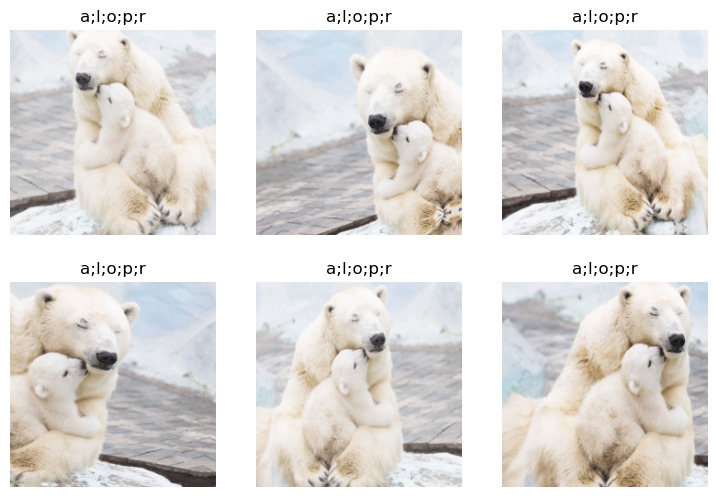

In [6]:
dls.train.show_batch(max_n=6,unique=True)

In [ ]:
bears.summary(path)

In [7]:
from fastai.callback.fp16 import *

In [8]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [14]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [15]:
learn = vision_learner(dls, 'convnext_small', metrics = partial(accuracy_multi,thresh=0.6))

SuggestedLRs(minimum=0.02089296132326126, steep=0.001737800776027143)

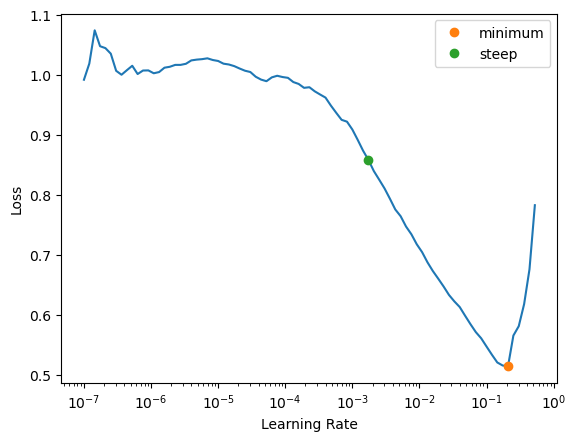

In [10]:
learn.lr_find(suggest_funcs=(minimum, steep))

In [16]:
learn.fine_tune(5, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.674699,0.226512,0.961976,00:43
1,0.393432,0.061631,0.994318,00:43
2,0.269830,0.030403,0.999126,00:43
3,0.187856,0.019114,0.998689,00:43


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.073791,0.010924,0.999126,02:46
1,0.073674,0.006012,0.999563,02:46
2,0.052195,0.003995,1.000000,02:47
3,0.054715,0.002629,1.000000,02:47
4,0.047345,0.002212,1.000000,02:49


In [17]:
interp = ClassificationInterpretation.from_learner(learn)

,target,predicted,probabilities,loss
0,a;l;o;p;r,a;l;o;p;r,"tensor([9.9229e-01, 6.7227e-04, 1.7058e-03, 7.6498e-04, 3.0719e-02, 1.6052e-03,\n 1.1070e-03, 1.4105e-03, 9.9905e-01, 1.7450e-03, 1.0000e+00, 9.9937e-01,\n 9.9999e-01, 2.4861e-01, 1.3358e-02, 4.2747e-03])",0.022069500759243965
1,a;b;c;k;l,a;b;c;k;l,"tensor([9.9904e-01, 9.9998e-01, 9.9997e-01, 1.5060e-04, 9.6189e-04, 2.1032e-02,\n 3.0532e-02, 9.9997e-01, 9.9985e-01, 2.1053e-03, 2.8904e-03, 4.1592e-04,\n 2.6941e-03, 1.4866e-03, 4.5543e-03, 1.8953e-02])",0.005492383148521185
2,a;d;n;p,a;d;n;p,"tensor([9.9829e-01, 6.6637e-03, 7.4475e-03, 9.9990e-01, 7.6683e-03, 1.0074e-02,\n 1.1085e-02, 3.1750e-03, 7.0873e-05, 9.9999e-01, 1.7430e-03, 9.9989e-01,\n 4.1333e-04, 8.0748e-03, 1.4150e-03, 6.6156e-03])",0.004164427984505892
3,a;d;n;p,a;d;n;p,"tensor([9.9767e-01, 7.5194e-03, 3.6297e-03, 9.9995e-01, 1.6987e-02, 2.0248e-03,\n 1.6533e-03, 3.4022e-03, 6.7246e-05, 9.9993e-01, 5.7528e-04, 9.9890e-01,\n 1.1732e-04, 2.2089e-02, 2.4462e-03, 1.5866e-03])",0.004131106659770012
4,a;d;n;p,a;d;n;p,"tensor([9.9847e-01, 8.9463e-03, 7.0540e-03, 9.9995e-01, 7.5087e-03, 7.8472e-03,\n 7.7017e-03, 3.5454e-03, 3.9026e-05, 1.0000e+00, 1.9184e-03, 9.9992e-01,\n 3.4640e-04, 8.2435e-03, 1.0485e-03, 5.6097e-03])",0.003855791874229908


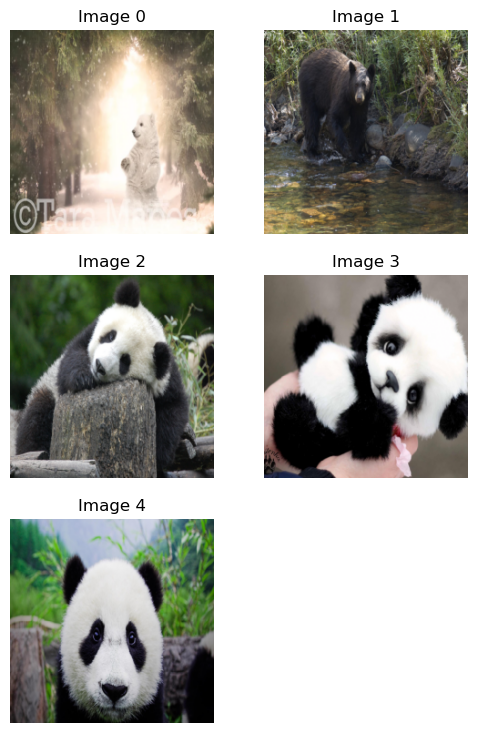

In [18]:
interp.plot_top_losses(5,nrows=3)

In [19]:
path_images = Path('images_to_test/')

In [20]:
def show_predict(img):
    l = learn.predict(img)
    if l[0] == ['a','d','n','p']:
        res = 'Panda bear'
    elif l[0] == ['g','i','l','r','y','z']:
        res = 'Grizzly Bear'
    elif l[0] == ['d','e','t','y']:
        res = 'Teddy Bear'
    elif l[0] == ['a','l','o','p','r']:
        res = 'Polar Bear'
    elif l[0] == ['a','b','c','k','l']:
        res = 'Black Bear'
    else:
        res = "Others"
    return res

In [26]:
show_predict(path_images/'polar2.jpg')

'Polar Bear'